# Physics-Informed Neural Networks (PINNs) for structural health monitoring: A case study for Kirchhoff-Love Plates
This notebook implements the concepts of informed NNs with structural boundary conditions under different uniformly distributed loads $UDLs$.



In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import itertools

from scipy import interpolate
from matplotlib.font_manager import FontProperties
from matplotlib.colors import ListedColormap
sns.set_theme(style="whitegrid")
from mpl_toolkits.mplot3d import Axes3D
from typing import Tuple, Callable, List, Union
from tensorflow.experimental.numpy import isclose
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

## Utility functions
We start by defining a few utility functions that will be useful later. The first, *compute_derivatives*, computes all the derivatives necessary to formulate NNs objective (it is a second order differential equation), while *compute_moments* is used for computing the boundary conditions.



In [ ]:
def compute_derivatives(x, y, p, u):
    """
    Computes the derivatives of `u` with respect to `x` and `y`.

    Parameters
    ----------
    x : tf.Tensor
        The x-coordinate of the collocation points, of shape (batch_size, 1).
    y : tf.Tensor
        The y-coordinate of the collocation points, of shape (batch_size, 1).
    u : tf.Tensor
        The prediction made by the PINN, of shape (batch_size, 1).

    Returns
    -------
    tuple
        The derivatives of `u` with respect to `x`, `y`, `xx`, `yy`, `xy`.
    """
    dudx = tf.gradients(u, x)[0]
    dudy = tf.gradients(u, y)[0]
    dudp = tf.gradients(u, p)[0]
    dudxx = tf.gradients(dudx, x)[0]
    dudyy = tf.gradients(dudy, y)[0]
    dudpp = tf.gradients(dudp, p)[0]

    return dudxx, dudyy, dudpp


def compute_moments(D, nue, dudxx, dudyy):
    """
    Computes the moments along the x and y axes.

    Parameters
    ----------
    D : float
        The flexural stiffness.
    nue : float
        Poisson's ratio.
    dudxx : tf.Tensor
        The second-order derivative of `u` with respect to `x`, of shape (batch_size, 1).
    dudyy : tf.Tensor
        The second-order derivative of `u` with respect to `y`, of shape (batch_size, 1).

    Returns
    -------
    tuple
        The moments along the x and y axes.
    """
    mx = -D * (dudxx + nue * dudyy)
    my = -D * (nue * dudxx + dudyy)
    return mx, my


Access to Google Drive so that the synthetic data can be uploaded.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Problem Setup
This class represents a plate under the Kirchhoff-Love plate bending theory. It provides a set of utility functions to train a Neural Network  on the Kirchhoff-Love theory. The class has functions that generate training  data, impoprt the analytical solution data, and  calculate loss.

In [ ]:
class Kirchhoffplate:
    """
    Class representing a Kirchhoff-Love plate, providing several methods for training a Neural Network.
    """
    def __init__(self, T: float, nue: float, E: float, H: float, W: float):
        """
        Initialize the Kirchhoffplate class.

        PARAMETERS
        ----------------
        T : float
            Thickness of the plate.
        nue : float
            Poisson's ratio.
        E : float
            Young's modulus.
        W : float
            Width of the plate.
        H : float
            Height of the plate.
        """
        self.T = T
        self.nue = nue
        self.E = E
        self.D = (E * T**3) / (12 * (1 - nue**2)) # flexural stiffnes of the plate
        self.H = H
        self.W = W
        self.num_terms = 4
        # Reading the CSV file and assigning the values
        df = pd.read_csv('/content/drive/MyDrive/sensor5.csv', encoding='ISO-8859-1')
        self.x_m = df['x_m'].values
        self.y_m = df['y_m'].values
        self.p_m = df['p_m'].values
        self.u_m = df['u_m'].values
        # Convert numpy array to tensorflow tensor
        self.x_m = tf.convert_to_tensor( self.x_m, dtype=tf.float32)
        self.y_m = tf.convert_to_tensor( self.y_m, dtype=tf.float32)
        self.p_m = tf.convert_to_tensor( self.p_m, dtype=tf.float32)
        self.u_m = tf.convert_to_tensor( self.u_m, dtype=tf.float32)

    def training_batch(self, batch_size_domain:int=800, batch_size_boundary:int=100) -> Tuple[tf.Tensor, tf.Tensor]:
        """
        Generates a batch of collocation points by randomly sampling `batch_size_domain` points inside the domain
        and `batch_size_boundary` points on each of the four boundaries.

        PARAMETERS
        --------------------
        batch_size_domain : int
            number of points to be sampled inside of the domain
        batch_size_boundary : int
            number of points to be sampled on each of the four boundaries
        """
        x_in = tf.random.uniform(shape=(batch_size_domain, 1), minval=0, maxval=self.W)
        x_b1 = tf.zeros(shape=(batch_size_boundary, 1))
        x_b2 = tf.zeros(shape=(batch_size_boundary, 1)) + self.W
        x_b3 = tf.random.uniform(shape=(batch_size_boundary, 1), minval=0, maxval=self.W)
        x_b4 = tf.random.uniform(shape=(batch_size_boundary, 1), minval=0, maxval=self.W)
        x_m = tf.constant(self.x_m, shape=(702,1), dtype=tf.float32)
        x = tf.concat([x_in, x_b1, x_b2, x_b3, x_b4, x_m], axis=0)

        y_in = tf.random.uniform(shape=(batch_size_domain, 1), minval=0, maxval=self.H)
        y_b1 = tf.random.uniform(shape=(batch_size_boundary, 1), minval=0, maxval=self.H)
        y_b2 = tf.random.uniform(shape=(batch_size_boundary, 1), minval=0, maxval=self.H)
        y_b3 = tf.zeros(shape=(batch_size_boundary, 1))
        y_b4 = tf.zeros(shape=(batch_size_boundary, 1)) + self.H
        y_m = tf.constant(self.y_m, shape=(702,1), dtype=tf.float32)
        y = tf.concat([y_in, y_b1, y_b2, y_b3, y_b4, y_m], axis=0)

        # Create a uniformly distributed load tensor
        p_in = tf.zeros(shape=(batch_size_domain, 1),  dtype=tf.float32)
        p_b1 = tf.zeros(shape=(batch_size_boundary, 1))
        p_b2 = tf.zeros(shape=(batch_size_boundary, 1))
        p_b3 = tf.zeros(shape=(batch_size_boundary, 1))
        p_b4 = tf.zeros(shape=(batch_size_boundary, 1))
        p_m = tf.constant(self.p_m, shape=(702,1), dtype=tf.float32)
        p = tf.concat([p_in, p_b1, p_b2, p_b3, p_b4, p_m], axis=0)
        return x, y, p

    def get_train_dataset(self, batch_size_domain:int=800, batch_size_boundary:int=100):
      def generator():
          while True:
            x, y, p = self.training_batch(batch_size_domain, batch_size_boundary)
            xyp = tf.concat([x, y, p], axis=-1)
            yield xyp, xyp
      return tf.data.Dataset.from_generator(generator,
        output_types=(tf.float32, tf.float32),
        output_shapes=((None, 3), (None, 3)))

    def compute_loss(self, x, y, p, preds):
        """
        Computes the boundaries loss for Kirchhoff's plate bending equation.

        Parameters
        ----------
        x : tf.Tensor of shape (batch_size, 1)
            x coordinate of the points in the current batch
        y : tf.Tensor of shape (batch_size, 1)
            y coordinate of the points in the current batch
        preds : tf.Tensor of shape (batch_size, 4)
            predictions made by our NN (dim 0) as well as dudxx (dim 1), dudyy (dim 2),
            dudpp (dim 3)"""

        u = preds[:, 0:1]
        dudxx = preds[:, 1:2]
        dudyy = preds[:, 2:3]
        dudpp = preds[:, 3:4]
        # determine which points are on the boundaries of the domain
        # if a point is on either of the boundaries, its value is 1 and 0 otherwise
        #EPS = 1e-7
        x_lower = tf.cast(isclose(x, 0.     , rtol=0., atol=EPS), dtype=tf.float32)
        x_upper = tf.cast(isclose(x, self.W, rtol=0., atol=EPS), dtype=tf.float32)
        y_lower = tf.cast(isclose(y, 0.     , rtol=0., atol=EPS), dtype=tf.float32)
        y_upper = tf.cast(isclose(y, self.H, rtol=0., atol=EPS), dtype=tf.float32)

        # compute 0th order boundary condition loss
        L_w = ((x_lower + x_upper + y_lower + y_upper) * u)**2
        # compute 2nd order boundary condition loss
        mx, my = compute_moments(self.D, self.nue, dudxx, dudyy)
        L_m = ((x_lower + x_upper + y_lower + y_upper) * mx)**2 + ((x_lower + x_upper + y_lower + y_upper) * my)**2

        L_p =(((x+y)+(x_lower + x_upper + y_lower + y_upper))*dudpp)**2
        # Calculate the indices for the last rows
        batch_size = tf.shape(preds)[0]
        indices = tf.range(batch_size - 702, batch_size, dtype=tf.int32)

        # Extract the corresponding predictions
        selected_preds = tf.gather(u, indices)
        # Compute the new loss term L_u
        u_m = tf.constant(self.u_m, shape=(702,1), dtype=tf.float32)
        L_u_partial = (selected_preds - u_m)**2
        # Create a tensor of zeros with the same shape as the existing loss terms
        L_u_full = tf.zeros_like(u)
        # Replace the last five eements with the values from L_u_partial
        L_D= tf.tensor_scatter_nd_update(L_u_full, tf.expand_dims(indices, axis=1), L_u_partial)

        return L_w, L_m, L_p, L_D


## Kirchhoff Loss Function Weights Balancing

In [ ]:
class KirchhoffLoss(tf.keras.losses.Loss):
    def __init__(self, plate: Kirchhoffplate, name: str = "kirchhoff_loss"):
        super().__init__(name=name)
        self.plate = plate
        self.weight_L_w = tf.Variable(1.0, trainable=True, constraint=lambda x: tf.clip_by_value(x, 0, 1))
        self.weight_L_m = tf.Variable(1.0, trainable=True, constraint=lambda x: tf.clip_by_value(x, 0, 1))
        self.weight_L_D = tf.Variable(1.0, trainable=True, constraint=lambda x: tf.clip_by_value(x, 0, 1))
        self.weight_L_p = tf.Variable(1.0, trainable=True, constraint=lambda x: tf.clip_by_value(x, 0, 1))

    def call(self, xyp, preds):
        x, y, p = xyp[:, :1], xyp[:, 1:2], xyp[:, 2:]
        L_w, L_m, L_p, L_D= self.plate.compute_loss(x, y, p, preds)

        # Add constraint to ensure the sum of the weights is 1
        weights_sum =  self.weight_L_w + self.weight_L_m + self.weight_L_p + self.weight_L_D


        self.weight_L_w.assign(self.weight_L_w / weights_sum)
        self.weight_L_m.assign(self.weight_L_m / weights_sum)
        self.weight_L_D.assign(self.weight_L_D / weights_sum)
        self.weight_L_p.assign(self.weight_L_p / weights_sum)

        loss = self.weight_L_w * tf.reduce_mean(L_w) + \
                     self.weight_L_m * tf.reduce_mean(L_m)  + \
                     self.weight_L_D * tf.reduce_mean(L_D) + \
                     self.weight_L_p * tf.reduce_mean(L_p)
        return loss

## Metrics for logging

### Custom Metric for logging Kirchhoff Loss Terms

In [ ]:
class KirchhoffMetric(tf.keras.metrics.Metric):
    """
    Kirchhoff metric to log the values of each loss term, i.e. L_w and L_m.
    """
    def __init__(self, plate: Kirchhoffplate, name='kirchhoff_metric', **kwargs):
        """Initialize Kirchhoff metric with a KirchhoffPDE instance and metric name.

        Parameters
        ----------
        plate : Kirchhoffplate
            Instance of the Kirchhoffplate.
        name : str, optional
            Name of the metric. Defaults to 'kirchhoff_metric'.
        """
        super().__init__(name=name, **kwargs)
        self.plate = plate
        self.L_w_mean = self.add_weight(name='L_w_mean', initializer='zeros')
        self.L_m_mean = self.add_weight(name='L_m_mean', initializer='zeros')
        self.L_D_mean = self.add_weight(name='L_D_mean', initializer='zeros')
        self.L_p_mean = self.add_weight(name='L_p_mean', initializer='zeros')

    def update_state(self, xyp, y_pred, sample_weight=None):
        x, y, p = xyp[:, :1], xyp[:, 1:2], xyp[:, 2:]
        L_w, L_m, L_D, L_p= self.plate.compute_loss(x, y, p, y_pred)
        self.L_w_mean.assign(tf.reduce_mean(L_w[:, 0], axis=0))
        self.L_m_mean.assign(tf.reduce_mean(L_m[:, 0], axis=0))
        self.L_D_mean.assign(tf.reduce_mean(L_D[:, 0], axis=0))
        self.L_p_mean.assign(tf.reduce_mean(L_p[:, 0], axis=0))
    def reset_state(self):
        self.L_w_mean.assign(0)
        self.L_m_mean.assign(0)
        self.L_D_mean.assign(0)
        self.L_p_mean.assign(0)
    def result(self):
        return {'L_w': self.L_w_mean, 'L_m': self.L_m_mean, 'L_D': self.L_D_mean, 'L_p': self.L_p_mean}


## NNs Model

In [ ]:
class KirchhoffPINN(tf.keras.Model):
    """
    This class is a implementation of a  neural network
    for the Kirchhoff plate bending.
    """
    def __init__(self, layer_widths: List[int]=[64, 64, 64, 64], activation: Union[str, Callable]='tanh', **kwargs):
        """
        Parameters
        ----------
        layer_widths : List[int], optional
            List of integers representing the widths of the hidden layers in the model.
        activation : Union[str, Callable], optional
            Activation function to be applied in each layer.
        """
        super().__init__(**kwargs)
        self.layer_sequence = [tf.keras.layers.Dense(width, activation=activation, kernel_initializer='glorot_normal') for width in layer_widths]
        self.layer_sequence.append(tf.keras.layers.Dense(1, kernel_initializer='glorot_normal'))

    def call(self, xyp, training=None, mask=None):
        x, y, p = xyp[:, :1], xyp[:, 1:2], xyp[:, 2:]
        u = tf.keras.layers.Concatenate()([x, y, p])
        for layer in self.layer_sequence:
            u = layer(u)

        dudxx, dudyy, dudpp = compute_derivatives(x, y, p, u)


        return tf.concat([u, dudxx, dudyy, dudpp], axis=-1)



*Concrete* Slab Parameters

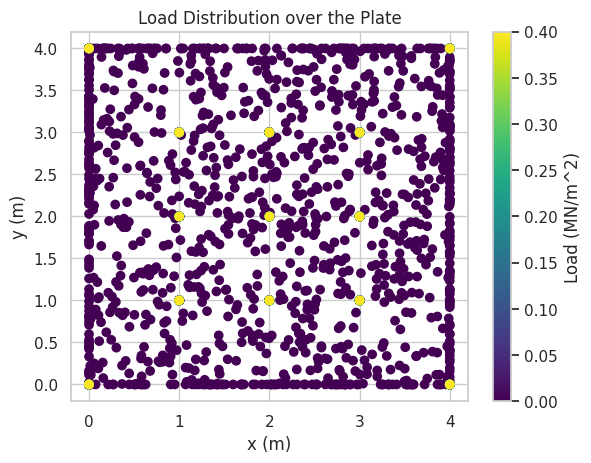

tf.Tensor(
[[0. ]
 [0. ]
 [0. ]
 ...
 [0.4]
 [0.4]
 [0.4]], shape=(1902, 1), dtype=float32)
tf.Tensor(
[[1.5373201]
 [1.4468164]
 [3.971661 ]
 ...
 [3.       ]
 [0.       ]
 [4.       ]], shape=(1902, 1), dtype=float32)
tf.Tensor(
[[0.29977608]
 [1.6673274 ]
 [0.45485783]
 ...
 [3.        ]
 [4.        ]
 [4.        ]], shape=(1902, 1), dtype=float32)


In [ ]:
W = 4
H = 4
T = 0.2
E = 31724
nue = 0.2
D = (E * T**3) / (12 * (1 - nue**2)) # flexural stiffnes of the plate
plate = Kirchhoffplate( T=T, nue=nue, E=E, W=W, H=H)
# Generate a training batch
x, y, p = plate.training_batch(batch_size_domain= 800, batch_size_boundary =100)

# Create a scatter plot of the load p over the plate
plt.scatter(x, y, c=p, cmap='viridis')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('Load Distribution over the Plate')
plt.colorbar(label='Load (MN/m^2)')
plt.show()


print(p)
print(x)
print(y)

PINNs model Hypereparameters

In [ ]:
pinn = KirchhoffPINN()
loss = KirchhoffLoss(plate)
pinn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=loss, metrics=[KirchhoffMetric(plate)])

In [ ]:
h = pinn.fit(
    plate.get_train_dataset(),
    epochs=50000,
    steps_per_epoch=50,
    callbacks=[
        ReduceLROnPlateau(monitor='loss', factor=0.1, patience=30, min_delta=0, verbose=True),
        EarlyStopping(monitor='loss', patience=100, restore_best_weights=True, verbose=True)
    ]
)

Visualise the progress of the several loss terms as well as the error against the analytical solution.

In [ ]:
loss_keys = ['L_w', 'L_m', 'L_D', 'L_p']
new_labels = {'L_w': 'w', 'L_m': 'm', 'L_D': 'D', 'L_p': 'p'}

# Specify the color for each line
colors = ['red', 'green', 'orange', 'blue']
cmap = ListedColormap(colors)

# Compute percentage contribution of each loss to total loss
percentage_contributions = {}
for key in loss_keys:
    # Avoid division by zero
    h.history['loss'] = np.where(np.array(h.history['loss']) == 0, np.finfo(float).eps, h.history['loss'])
    percentage_contributions[key] = 100 * np.log(np.array(h.history[key])) / np.log(np.array(h.history['loss']))

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.5), dpi=1000)

for i, key in enumerate(loss_keys):
    ax1.plot(percentage_contributions[key], label='$\u2112_{' + new_labels[key].replace('_', '-') + '}$', color=cmap(i))

ax1.set_xlabel('Epochs', fontweight='bold')
ax1.set_ylabel('% Loss Components Contribution', fontweight='bold')
ax1.legend(prop=FontProperties(weight='bold'))
ax1.grid(False)
ax1.text(0.02, 1.1, '(a)', transform=ax1.transAxes, fontsize=12, fontweight='bold', va='top', ha='left')
#ax1.tick_params(axis='both', which='both', labelweight='bold')

# Summarize history for loss
tloss = np.log(h.history['loss'])
# Setting "Times New Roman" as the default font
plt.rc('font', family='Liberation Serif')
ax2.plot(tloss, label='Total Loss', color='darkblue')
ax2.set_xlabel('Epochs', fontweight='bold')
ax2.set_ylabel('Log $L_2$ loss', fontweight='bold')
ax2.legend()
ax2.grid(False)
ax2.text(0.02, 1.1, '(b)', transform=ax2.transAxes, fontsize=12, fontweight='bold', va='top', ha='left')
#ax2.tick_params(axis='both', which='both', labelweight='bold')

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.3)

plt.tight_layout()
plt.savefig('kirchhoff_total_loss')
plt.show()


In [ ]:

x_values = [0, 4, 1, 3, 2, 2, 2, 1, 3, 1, 3, 0, 4]
y_values = [0, 0, 1, 1, 1, 3, 2, 2, 2, 3, 3, 4, 4]
p_values = [0.00948, 0.02, 0.15, 0.45, 0.5, 0.55 ]

for p_value in p_values:
    xy_values = [[x, y, p_value] for x, y in zip(x_values, y_values)]

    input_data = np.array(xy_values, dtype=np.float32)

    # Predict the model for the new x, y data
    predictions = pinn.predict(input_data)

    # Create separate lists for u, dudxx, and dudyy predictions
    u_pred_values = []
    dudxx_pred_values = []
    dudyy_pred_values = []
    dudpp_pred_values = []
    for x, y, p in zip(x_values, y_values, itertools.repeat(p_value, len(x_values))):
        index = np.where((input_data[:, 0] == x) & (input_data[:, 1] == y) & (input_data[:, 2] == p))[0][0]
        u_value = predictions[index, 0]
        dudxx_value = predictions[index, 1]
        dudyy_value = predictions[index, 2]
        dudpp_values = predictions[index, 3]
        u_pred_values.append(u_value)
        dudxx_pred_values.append(dudxx_value)
        dudyy_pred_values.append(dudyy_value)
        dudpp_pred_values.append(dudpp_values)

    mx = [-D * (x + (nue * y)) for x, y in zip(dudxx_pred_values, dudyy_pred_values)]
    my = [-D * ((nue * x) + y) for x, y in zip(dudxx_pred_values, dudyy_pred_values)]

    u = [round(value, 6) for value in u_pred_values ]
    mx_rounded = [round(value, 6) for value in mx]
    my_rounded = [round(value, 6) for value in my]
    dudpp = [round(value, 6) for value in dudpp_pred_values ]

    u_abs = [abs(value) for value in u]
    mx_abs = [abs(value) for value in mx_rounded]
    my_abs = [abs(value) for value in my_rounded]

    print(f"For p_value = {p_value}:")
    print("u =", u_abs)
    print("mx =", mx_abs)
    print("my =", my_abs)
    print("dudpp =", dudpp)
    print("\n")


1/1 [==============================] - 0s 27ms/step
For p_value = 0.00948:
u = [1.1e-05, 5e-06, 0.000244, 0.000244, 0.000314, 0.000388, 0.000451, 0.000349, 0.000355, 0.000298, 0.000298, 1e-05, 1.8e-05]
mx = [5e-06, 9e-06, 0.002924, 0.001412, 0.0036, 0.004949, 0.005632, 0.004714, 0.002872, 0.004464, 0.002861, 1.3e-05, 8e-06]
my = [4e-06, 2e-06, 0.001545, 0.001363, 0.001808, 0.004659, 0.005772, 0.004567, 0.004497, 0.003945, 0.003593, 5e-06, 2e-06]
dudpp = [-9.5e-05, 5.8e-05, -1.6e-05, 4.8e-05, -3e-05, 3.3e-05, -1.6e-05, -3e-06, 5.9e-05, 3.3e-05, -4.2e-05, 7.2e-05, -2e-06]


1/1 [==============================] - 0s 28ms/step
For p_value = 0.02:
u = [1.1e-05, 6e-06, 0.000528, 0.000515, 0.000662, 0.000735, 0.000874, 0.000688, 0.000701, 0.000564, 0.000578, 1.1e-05, 1.8e-05]
mx = [3e-06, 8e-06, 0.00709, 0.003185, 0.007478, 0.008703, 0.010076, 0.009049, 0.005143, 0.007593, 0.004915, 8e-06, 1e-06]
my = [1e-06, 5e-06, 0.005311, 0.004205, 0.005742, 0.006923, 0.010049, 0.008244, 0.008108, 0.00571

Visualise the progress of the several loss terms as well as the error against the analytical solution.

In [ ]:

def visualise(u_real, mx_real, my_real, u_pred, mx_pred, my_pred):
    sq_errors = [tf.square(u_pred - u_real), tf.square(mx_pred - mx_real), tf.square(my_pred - my_real)]

    real_values = [u_real, mx_real, my_real]
    pred_values = [u_pred, mx_pred, my_pred]
    titles = [['Predicted Deformation (u)', 'Real Deformation (u)', 'Squared Error (u)'],
              ['Predicted Moment (mx)', 'Real Moment (mx)', 'Squared Error (mx)'],
              ['Predicted Moment (my)', 'Real Moment (my)', 'Squared Error (my)']]

    # Define x and y axis
    x = tf.constant([0, 4, 1, 3, 2, 2, 2, 1, 3, 1, 3, 0, 4], shape=(13, 1), dtype=tf.float32)
    y = tf.constant([0, 0, 1, 1, 1, 3, 2, 2, 2, 3, 3, 4, 4], shape=(13, 1), dtype=tf.float32)
    # Convert x and y tensors to numpy arrays
    x = x.numpy()
    y = y.numpy()
    # Create a meshgrid of x and y coordinates for contour plot
    X, Y = np.meshgrid(np.linspace(x.min(), x.max(), 150), np.linspace(y.min(), y.max(), 150))

    fig, axs = plt.subplots(3, 3, figsize=(18, 15))

    for i in range(3):
        for j in range(3):
            interp = interpolate.griddata((x.flatten(), y.flatten()),
                                          pred_values[i] if j == 0 else real_values[i] if j == 1 else sq_errors[i],
                                          (X, Y), method='cubic')

            im = axs[i, j].imshow(interp, cmap='jet', origin='lower', aspect='equal', extent=[0, 4, 0, 4])
            cb = fig.colorbar(im, ax=axs[i, j], shrink=1)
            axs[i, j].set_title(titles[i][j])
            axs[i, j].set_xlabel('x [m]')
            axs[i, j].set_xticks([0, 4])

            if j == 0:
                axs[i, j].set_ylabel('y [m]')
            axs[i, j].set_yticks([0, 4])

    plt.tight_layout()
    plt.show()

    u_max_sq_error = np.max(sq_errors[0])
    mx_max_sq_error = np.max(sq_errors[1])
    my_max_sq_error = np.max(sq_errors[2])
    print("Maximum squared error (u):", u_max_sq_error)
    print("Maximum squared error (mx):", mx_max_sq_error)
    print("Maximum squared error (my):", my_max_sq_error)

    u_rmse = tf.sqrt(tf.reduce_mean(sq_errors[0]))
    mx_rmse = tf.sqrt(tf.reduce_mean(sq_errors[1]))
    my_rmse = tf.sqrt(tf.reduce_mean(sq_errors[2]))

    # Calculate CV(RMSE) for each variable
    u_cv_rmse = (u_rmse / tf.reduce_mean(u_real)) * 100
    mx_cv_rmse = (mx_rmse / tf.reduce_mean(mx_real)) * 100
    my_cv_rmse = (my_rmse / tf.reduce_mean(my_real)) * 100

    print("CV(RMSE) for Deformation (u):", u_cv_rmse.numpy(), '%')
    print("CV(RMSE) for Moment (mx):", mx_cv_rmse.numpy(), '%')
    print("CV(RMSE) for Moment (my):", my_cv_rmse.numpy(), '%')


*Visualise* the progress of the results of predictions.


In [ ]:
# Read the CSV file
data = pd.read_csv('/content/drive/MyDrive/real_data1.csv', encoding='ISO-8859-1')
print(data.columns)


# Filter data by p_value and extract the corresponding columns
def get_real_data(p_value):
    filtered_data = data[data["p_value "] == p_value]
    u_real = filtered_data["u_real"].values
    mx_real = filtered_data["mx_real"].values
    my_real = filtered_data["my_real"].values

    return u_real, mx_real, my_real


# Get real data for each p_value
u_real_00948, mx_real_00948, my_real_00948 = get_real_data(0.00948)
u_real_02, mx_real_02, my_real_02 = get_real_data(0.02)
u_real_15, mx_real_15, my_real_15 = get_real_data(0.15)
u_real_045, mx_real_045, my_real_045 = get_real_data(0.45)
u_real_05, mx_real_05, my_real_05 = get_real_data(0.5)
u_real_055, mx_real_055, my_real_055 = get_real_data(0.55)

# Convert real data to tensors
u_real_00948 = tf.constant(u_real_00948, shape=(13, 1), dtype=tf.float32)
mx_real_00948 = tf.constant(mx_real_00948, shape=(13, 1), dtype=tf.float32)
my_real_00948 = tf.constant(my_real_00948, shape=(13, 1), dtype=tf.float32)

u_real_02 = tf.constant(u_real_02, shape=(13, 1), dtype=tf.float32)
mx_real_02 = tf.constant(mx_real_02, shape=(13, 1), dtype=tf.float32)
my_real_02 = tf.constant(my_real_02, shape=(13, 1), dtype=tf.float32)

u_real_15 = tf.constant(u_real_15, shape=(13, 1), dtype=tf.float32)
mx_real_15 = tf.constant(mx_real_15, shape=(13, 1), dtype=tf.float32)
my_real_15 = tf.constant(my_real_15, shape=(13, 1), dtype=tf.float32)

u_real_045 = tf.constant(u_real_045, shape=(13, 1), dtype=tf.float32)
mx_real_045 = tf.constant(mx_real_045, shape=(13, 1), dtype=tf.float32)
my_real_045 = tf.constant(my_real_045, shape=(13, 1), dtype=tf.float32)

u_real_05 = tf.constant(u_real_05, shape=(13, 1), dtype=tf.float32)
mx_real_05 = tf.constant(mx_real_05, shape=(13, 1), dtype=tf.float32)
my_real_05 = tf.constant(my_real_05, shape=(13, 1), dtype=tf.float32)

u_real_055 = tf.constant(u_real_055, shape=(13, 1), dtype=tf.float32)
mx_real_055 = tf.constant(mx_real_055, shape=(13, 1), dtype=tf.float32)
my_real_055 = tf.constant(my_real_055, shape=(13, 1), dtype=tf.float32)

Index(['p_value ', 'u_real', 'mx_real', 'my_real'], dtype='object')


In [ ]:
real_values_dict = {
    0.00948: {
        'u_real': u_real_00948,
        'mx_real': mx_real_00948,
        'my_real': my_real_00948,
    },
    0.02: {
        'u_real': u_real_02,
        'mx_real': mx_real_02,
        'my_real': my_real_02,
    },
    0.15: {
        'u_real': u_real_15,
        'mx_real': mx_real_15,
        'my_real': my_real_15,
    },
    0.45: {
        'u_real': u_real_045,
        'mx_real': mx_real_045,
        'my_real': my_real_045,
    },
    0.50: {
        'u_real': u_real_05,
        'mx_real': mx_real_05,
        'my_real': my_real_05,
    },
    0.55: {
        'u_real': u_real_055,
        'mx_real': mx_real_055,
        'my_real': my_real_055,
    },
}

for p_value in p_values:
    xy_values = [[x, y, p_value] for x, y in zip(x_values, y_values)]

    input_data = np.array(xy_values, dtype=np.float32)

    # Predict the model for the new x, y data
    predictions = pinn.predict(input_data)

    # Create separate lists for u, dudxx, and dudyy predictions
    u_pred_values = []
    dudxx_pred_values = []
    dudyy_pred_values = []

    for x, y, p in zip(x_values, y_values, itertools.repeat(p_value, len(x_values))):
        index = np.where((input_data[:, 0] == x) & (input_data[:, 1] == y) & (input_data[:, 2] == p))[0][0]
        u_value = predictions[index, 0]
        dudxx_value = predictions[index, 1]
        dudyy_value = predictions[index, 2]
        u_pred_values.append(u_value)
        dudxx_pred_values.append(dudxx_value)
        dudyy_pred_values.append(dudyy_value)

    mx = [-D * (x + nue * y) for x, y in zip(dudxx_pred_values, dudyy_pred_values)]
    my = [-D * (nue * x + y) for x, y in zip(dudxx_pred_values, dudyy_pred_values)]

    u = [round(value, 6) for value in u_pred_values ]
    mx_rounded = [round(value, 6) for value in mx]
    my_rounded = [round(value, 6) for value in my]

    u_abs = [abs(value) for value in u]
    mx_abs = [abs(value) for value in mx_rounded]
    my_abs = [abs(value) for value in my_rounded]

    u_pred = tf.constant(u_abs, shape=(13, 1), dtype=tf.float32)
    mx_pred = tf.constant(mx_abs, shape=(13, 1), dtype=tf.float32)
    my_pred = tf.constant(my_abs, shape=(13, 1), dtype=tf.float32)

    u_real = real_values_dict[p_value]['u_real']
    mx_real = real_values_dict[p_value]['mx_real']
    my_real = real_values_dict[p_value]['my_real']
    print(f"For p_value = {p_value}:")
    visualise(u_real, mx_real, my_real, u_pred, mx_pred, my_pred)
    print("\n")
